In [1]:
from Functions import *

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Loading the Data**

In [5]:
data = load_data()
# dropping my obvious outlier
data = remove_outliers(data)

### My Basic Preprocessing Pipeline

There are a number of preprocessing steps I attempt with each model before adding the classifier. My basic pipeline is as follows: 

1. *Imputer*: Imputes values for observations with null values. My default strategy is 'median'. 
<br><br>
2. *Resampling*: There are very few POIs relative to the total number of observations. Most classifiers struggle with highly imbalanced classes like this. I use an implementation of the SMOTE algorithm to artificially generate new POI observations in order to balance my dataset. 
<br><br>
3. *Feature Selection*: In order to eliminate noise and maintain a parsimonious model, I want to keep only the most valuable features. I used Sklearn's SelectKBest with ANOVA F-scores as the scoring metric. It limits me to "k" features with highest F-scores (A metric for how well the feature separates my classes). 
<br><br>
4. *Feature Scaling*: A number of my features are on wildly different scales which means that some algorithms will overweight certain features when determining the class. My default scaler standardizes all my features (set mean to 0 and std to 1) to account for this. 
<br><br>
5. *Principal Component Analysis*: PCA does a number of things. First it can help reduce noise by finding combinations of features that explain the most variation in my data so I can use a smaller number of features when actually fitting the model. Second it projects all features onto orthogonal axis so I don't need to worry about issues of multicollinearity which can affect the performance of some models.  

In [5]:
for step, impl in base_pipeline:
    print('Step:', step)
    print('Implementation:', impl)
    print('=====================\n')

Step: imputer
Implementation: Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Step: resampling
Implementation: SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)

Step: selection
Implementation: SelectKBest(k=10, score_func=<function f_classif at 0x0000027AB6A5B488>)

Step: scaler
Implementation: StandardScaler(copy=True, with_mean=True, with_std=True)

Step: pca
Implementation: PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)



### Pipeline Tuning

Prior to tuning the hyperparameters, I use grid search cross validation to make sure I am using the optimal pipeline permuation for each model. I chose to keep these separate from the hyperparameter tuning to keep the number of permutations I had to test from getting out of control. The parameters I adjust to create each pipeline permuation are:

1. *Feature Scaling*: I try each pipeline with and without feature scaling. 
<br><br>
2. *Number of Features in Feature Selection*: I try a number of different values for k (The # of features to keep)
<br><br>
3. *PCA*: I try the pipeline with no PCA and PCA with a number of different components being kept. 

In [6]:
for param, vals in base_param_grid.items():
    print('Parameter:', param)
    print('Possible Values:')
    pprint(vals)
    print('=====================\n')

Parameter: selection__k
Possible Values:
[7, 10, 15]

Parameter: scaler
Possible Values:
[None, StandardScaler(copy=True, with_mean=True, with_std=True)]

Parameter: pca
Possible Values:
[None,
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)]



In [6]:
X, y = data[all_features], data.poi

## Model Selection

I tried a variety of different classifiers, using GridSearchCV to find the optimal pipeline for each one. Displayed below are the scores for the model, a confusion matrix, the optimal pipeline parameters, and information about which features were used. 

**Scores Explained:** I use several metrics to evaluate the model
1. *Accuracy*: The proportion of correct classifications
2. *Recall*: The proportion of POI's identified
3. *Precision*: A measure of how discerning the model is
4. *F1*: A combination of precision and recall which givens an overall measure of how effective the model is. 

*Note*: In all models GridSearchCV is optimizing for precision as I had difficulty getting that over the required threshhold. 

#### Logistic Regression

In [7]:
clf = [('clf', LogisticRegression())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.798761337868
Average Precision:  0.265421152921
Average Recall: 0.333333333333
Average F1:  0.280404262118

Pipeline Parameters:
{'pca': PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': None,
 'selection__k': 15}

Retained Features:

expenses
shared_receipt_with_poi
exercised_stock_options
from_poi_to_this_person
total_stock_value
salary
bonus
restricted_stock
long_term_incentive
deferred_income
other
total_payments
loan_advances
from_messages
to_messages
Number of principal components retained: 6


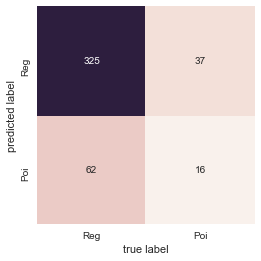

In [8]:
lr_grid = evaluate_model(model, param_grid, X, y, optimize='precision')

#### K Nearest Neighbors

In [83]:
clf = [('clf', KNeighborsClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.725943877551
Average Precision:  0.251201136261
Average Recall: 0.571111111111
Average F1:  0.342235730472

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 15}

Retained Features:

from_poi_to_this_person
bonus
shared_receipt_with_poi
salary
exercised_stock_options
long_term_incentive
total_stock_value
restricted_stock
total_payments
other
from_this_person_to_poi
loan_advances
deferral_payments
to_messages
director_fees


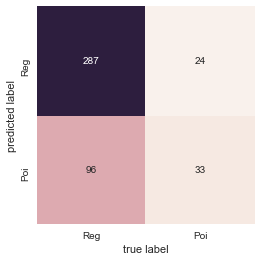

In [84]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

#### SVM

In [ ]:
clf = [('clf', SVC())]
model = imb_pipeline(base_pipeline + clf)
# extra_params = {'clf__kernel': ['linear', 'rbf']}
param_grid = base_param_grid.copy()
# param_grid.update(extra_params)

In [ ]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

#### Naive Bayes

In [75]:
clf = [('clf', GaussianNB())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.803117913832
Average Precision:  0.31138010138
Average Recall: 0.375555555556
Average F1:  0.318231779996

Pipeline Parameters:
{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 10}

Retained Features:

bonus
from_poi_to_this_person
shared_receipt_with_poi
long_term_incentive
from_this_person_to_poi
salary
exercised_stock_options
total_stock_value
expenses
deferral_payments
Number of principal components retained: 2


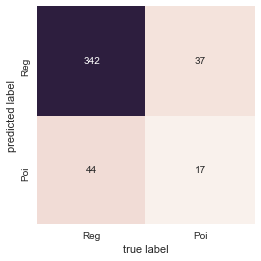

In [77]:
nb_grid = evaluate_model(model, param_grid, X, y, optimize='f1')

#### Decision Tree

In [85]:
clf = [('clf', DecisionTreeClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.782757936508
Average Precision:  0.231600605277
Average Recall: 0.311111111111
Average F1:  0.254399764046

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 10}

Retained Features:

exercised_stock_options
total_stock_value
salary
restricted_stock
bonus
shared_receipt_with_poi
deferred_income
long_term_incentive
from_this_person_to_poi
total_payments


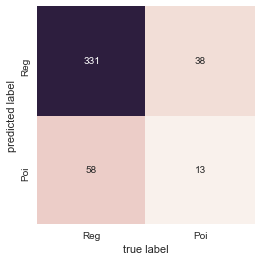

In [86]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

### Ensemble Methods

#### Random Forest

In [87]:
clf = [('clf', RandomForestClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.80089569161
Average Precision:  0.254268766321
Average Recall: 0.31
Average F1:  0.263709098744

Pipeline Parameters:
{'pca': None, 'scaler': None, 'selection__k': 7}

Retained Features:

from_poi_to_this_person
total_payments
bonus
long_term_incentive
deferred_income
exercised_stock_options
salary


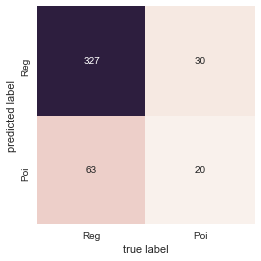

In [88]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

#### Ada Boost

In [89]:
clf = [('clf', AdaBoostClassifier())]
model = imb_pipeline(base_pipeline + clf)
param_grid = base_param_grid.copy()


SCORES:

Average Accuracy: 0.802619047619
Average Precision:  0.257911505162
Average Recall: 0.29
Average F1:  0.260617494362

Pipeline Parameters:
{'pca': None,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 15}

Retained Features:

total_stock_value
exercised_stock_options
restricted_stock
deferred_income
salary
bonus
long_term_incentive
expenses
shared_receipt_with_poi
total_payments
from_this_person_to_poi
deferral_payments
loan_advances
director_fees
other


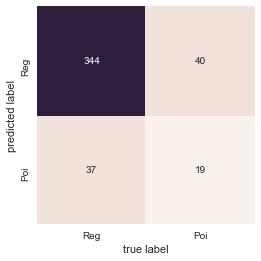

In [90]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

## Careful Tuning

Tuning the hyperparameters in selected models

### Logistic Regression

In [9]:
clf = [('clf', LogisticRegression())]
model = imb_pipeline(base_pipeline + clf)

In [10]:
param_grid = {}
for k, v in lr_grid.best_params_.items():
    if v == 'None':
        v = None
    param_grid[k] = [v]

In [11]:
param_grid['clf__penalty'] = ['l1', 'l2']
param_grid['clf__C'] = [0.1, 1, 10, 100, 1000, 5000]


SCORES:

Average Accuracy: 0.801524943311
Average Precision:  0.28483699144
Average Recall: 0.36
Average F1:  0.300858899343

Pipeline Parameters:
{'clf__C': 100,
 'clf__penalty': 'l2',
 'pca': PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': None,
 'selection__k': 15}

Retained Features:

from_poi_to_this_person
shared_receipt_with_poi
salary
bonus
exercised_stock_options
total_stock_value
restricted_stock
expenses
deferral_payments
long_term_incentive
total_payments
from_messages
loan_advances
to_messages
director_fees
Number of principal components retained: 6


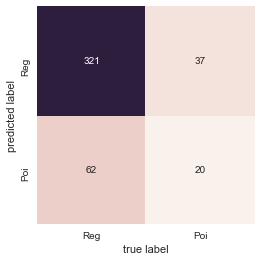

In [12]:
grid = evaluate_model(model, param_grid, X, y, optimize='precision')

In [96]:
import pickle

In [97]:
pickle.dump(data, open('my_dataset.pkl', 'wb'))
pickle.dump(grid.best_estimator_, open('my_classifier.pkl', 'wb'))
pickle.dump(all_features, open('my_feature_list.pkl', 'wb'))

### Naive Bayes

In [78]:
clf = [('clf', GaussianNB())]
model = imb_pipeline(base_pipeline + clf)

In [79]:
param_grid = {}
for k, v in nb_grid.best_params_.items():
    if v == 'None':
        v = None
    param_grid[k] = [v]

In [80]:
param_grid['clf__priors'] = [None, [.5, .5]]


SCORES:

Average Accuracy: 0.804503968254
Average Precision:  0.308115005507
Average Recall: 0.358888888889
Average F1:  0.314440201181

Pipeline Parameters:
{'clf__priors': None,
 'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'selection__k': 10}

Retained Features:

shared_receipt_with_poi
salary
deferred_income
long_term_incentive
total_stock_value
exercised_stock_options
restricted_stock
bonus
from_poi_to_this_person
expenses
Number of principal components retained: 2


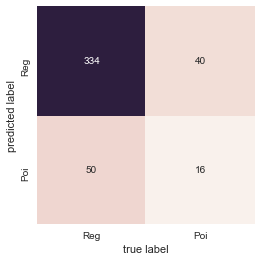

In [82]:
grid = evaluate_model(model, param_grid, X, y, optimize='f1')